Neste trabalho apresentaremos um método de detectar objetos em uma imagem a partir de um função que calcula **diferenças quadraticas**. Ma é possível que exista diferenças na coloração do objeto a ser procurado na imagem, a partir disto temos que aplicar alguns filtros para equalizar a iluminação da imagem.


# Importando bibliotecas:

In [1]:
import cv2
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Transformação pontual de lei de potência

Utilizaremos a transformação Gamma para equalizar as diferenças de iluminação da imagem, ela utiliza a formula s = c * ry.


**Diferença Quadrática**
**Assim, é possível observar por meio do gráfico que valores altos de entrada, após o processamento gamma, saem com um valor mais próximo ao 0, invertendo cas ocorra o contrário. Um detalhe muito importante explorado adiante..**


In [2]:
#Recebe uma imagem
def power_law_tranformation(obj, gamma):
  obj_gamma = np.zeros(obj.shape, dtype=np.uint8)
  obj_gamma = 255*(obj/255)**gamma
  #retorna a imagem com o filtro gamma aplicado
  return obj_gamma

# Correlação cruzada
Com a correlação cruzada iremos obter a diferença quadratica nas imagens.

In [3]:
#recebe a imagem e o objeto para se localizar
def square_correlation(img, obj):
  w = np.ones(obj.shape)
  imgW = scipy.signal.correlate(img**2, w, mode='same')
  imgObj = scipy.signal.correlate(img, obj, mode='same')
  img_dif = imgW + np.sum(obj**2) - 2*imgObj
  # Remove a borda
  half_row_obj = obj.shape[0]//2
  half_col_obj = obj.shape[1]//2
  img_dif_center = img_dif[half_row_obj:-half_row_obj, 
                          half_col_obj:-half_col_obj]
  #retorna a imagem com as diferenças
  return img_dif

# Marcando o objeto a ser localizado com um retângulo

Utilizando a biblioteca cv2 vamos desenhar um retangulo demarcando o objeto sobre a imagem original.



In [4]:
def draw_rectangle(img, center, size):
  half_num_rows_obj = size[0]//2
  half_num_cols_obj = size[1]//2
  img_rectangle = img.copy()
  pt1 = (center[1]-half_num_cols_obj, center[0]-half_num_rows_obj)
  pt2 = (center[1]+half_num_cols_obj, center[0]+half_num_rows_obj)
  #retangulo preto para contrastar com a imagem que tem fundo claro
  cv2.rectangle(img_rectangle, pt1=pt1, pt2=pt2, color=0, thickness=3)
  return img_rectangle

# Melhor resultado da busca
Como a iluminação das imagens não são 100% iguais precisamos fazer um sistema de pontuação com a melhor matriz, na função abaixo vamos obter um varios valores de "match", o menor valor resultará na imagem mais próxima do objeto.


In [5]:
#procura a posição da matri com menor valor
def find_minimum(img):
  num_rows, num_cols = img.shape
  menor_valor = img[0,0]
  indice_menor_valor = (0, 0)
  for row in range(num_rows):
    for col in range(num_cols):
      valor = img[row,col]
      if valor<=menor_valor:
        menor_valor = valor
        indice_menor_valor = (row, col)
  return menor_valor, indice_menor_valor

# Localização dos objetos
Está será a função capaz de mostrar o objeto localizado caso nenhum obstáculo ocorra durante o processamento. Basicamente ele mesclará todos os passos anteriores variando a transformação Gamma, assim quanto mais variações, mais chances de localizar o objeto.



In [6]:
#recebe a imagem, o objeto e o fator de iluminação que serve para garantir que o excesso da mudança de iluminação assim previne error na busca
def search_object(img, obj, obj_lighting):
  # Lendo as imagens e as convertendo em float.
  img = img
  img = img.astype(float)
  obj = obj
  obj = obj.astype(float)
 
  position_global = (0,0)
  min_global = np.Inf

  #conferindo o fator de iliminação
  if obj_lighting == "both":
    values_of_gamma = np.linspace(0.01, 5.0, 50)
  elif obj_lighting == "dark":
    values_of_gamma = np.linspace(0.01, 1, 14)
  if obj_lighting == "white":
    values_of_gamma = np.linspace(1, 5.0, 14)
  else:
    print("argument invalid")
    exit()

  #Calculando para diferentes valores de gamma
  for gamma in values_of_gamma:
    gamma_obj = power_law_tranformation(obj, gamma)
    diff = square_correlation(img, gamma_obj)
    min, pos = find_minimum(diff)
    #caso ache uma melhor pontuação na varredura, substitui
    if min < min_global:
      min_global = min
      position_global = pos
  return draw_rectangle(img, position_global, obj.shape)

# Altera do gamma 
Na função abaixo alteramos o gamma do objeto para buscar com diferentes tipos de iluminação na imagem

In [7]:
def gera_gamma(img, gamma):
  num_lin, num_col = img.shape
  img_gamma = np.zeros([num_lin, num_col], dtype = np.uint8)
  img_gamma = 255*((img/255)**gamma)         
  return img_gamma


# Testando a aplicação
Para testar a aplicação, utilizamos vamos procurar o passaro de asas abertas, nele nós variamos o gamma para procurar com diferentes tipos de iluminação.

argument invalid


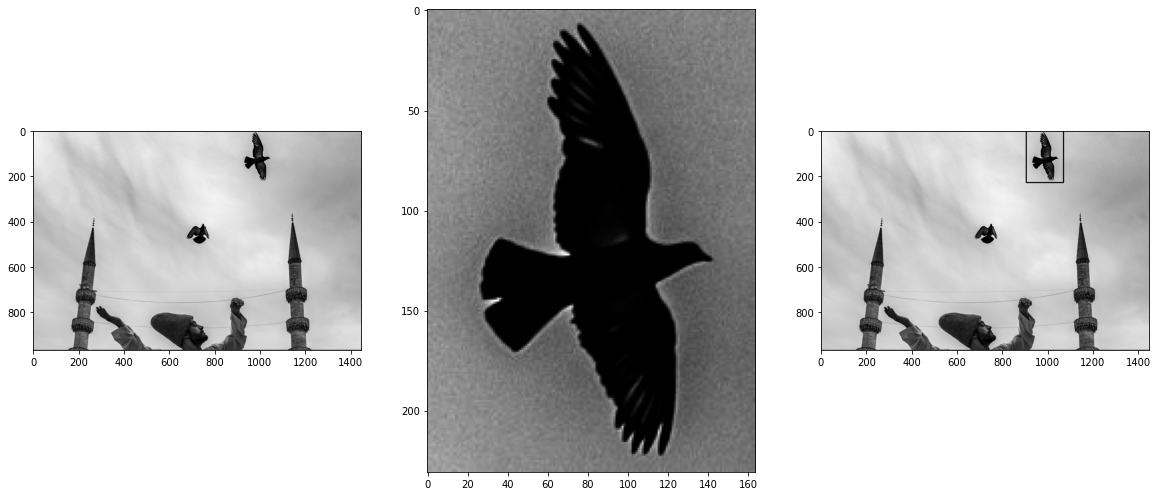

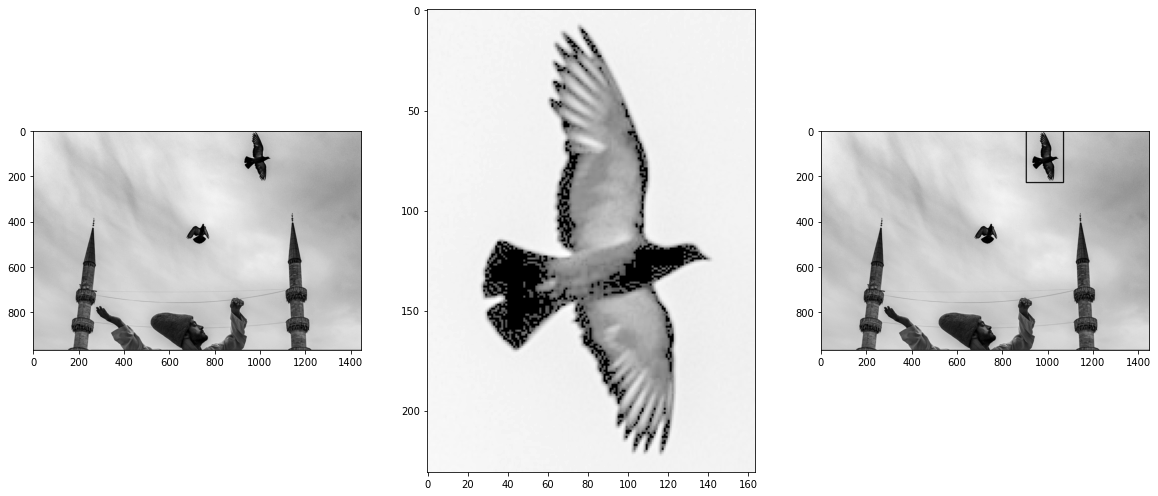

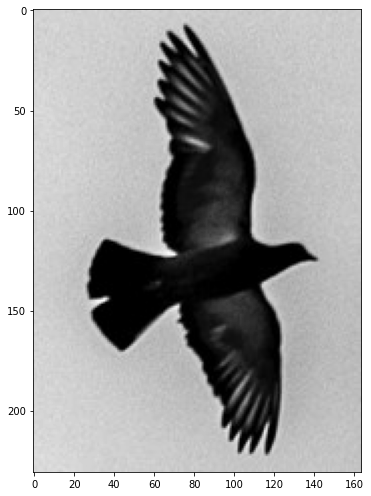

In [8]:
img = plt.imread("images/paisage.tiff")
obj = plt.imread("images/bird.tiff")
objDark = gera_gamma(obj,3)
objWhite = gera_gamma(obj,0.2)

# Teste com a ave escura
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(objDark, 'gray')
result = search_object(img, objDark, "dark")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

# Teste com a ava clara
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(objWhite, 'gray')
result = search_object(img, objWhite, "white")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

#plotando objeto original
plt.figure(figsize=[20,20])
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')